In [1]:

# %matplotlib inline
%matplotlib inline
%load_ext autoreload
%autoreload 1

import os
import re
import glob
import pandas as pd
import numpy as np
from numpy import linalg as LA
import numpy.lib.recfunctions as rf
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist

from ipywidgets import interactive, interactive_output, interact_manual

import ipywidgets as widgets
# import cv2
import time
import mediapy
import torch
from tqdm.notebook import tqdm
# mpl.rcParams['figure.figsize'] = [16.0, 12.0]

# %aimport plot_functions, seqslam_tools
# from seqslam_tools import seqSLAM_from_distMat, seqSLAM_from_distMatGPU, seqSLAM_from_distMatGPU_multi, seqSLAM_from_distMatGPU_multi_precomputed
# from plot_functions import compare_images_triple, plot_image_on_ax, getPRCurveWrapper, getPRCurveWrapperFromScores, getPAt100R, getPAt100RFromPRVals, getRAtXPFromPRVals

import seaborn as sns; sns.set(); sns.set_style("whitegrid"); sns.set_context("notebook")
# import seaborn_image as isns; isns.set_context("notebook"); isns.set_image(origin="upper")

import tonic
import tonic.transforms as transforms



In [2]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def apply_filter(ref, qry, filter_size, method, domain = "time"):
    dmat = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))
    
    for filter_ind in np.arange(len(ref)-filter_size+1):
        filter = qry[filter_ind:filter_ind+filter_size]

        if method == "diff":
            corr_diff = np.zeros(dmat.shape[0])
            corr_test = np.copy(corr_diff)

            for idx in np.arange(len(corr_diff)):
                ref_subseq = ref[idx:idx+filter_size]

                if domain == "freq":
                    ref_subseq = np.fft.fft(ref_subseq)
                    filter = np.fft.fft(filter)

                # corr_diff[idx] = np.sum(np.abs(ref_subseq - filter))
                corr_diff[idx] = np.linalg.norm(ref_subseq - filter)

                # corr_test[idx] = np.sum((ref[idx:idx+filter_size] * filter))

            corr_diff_norm = corr_diff / np.max(corr_diff)
            dmat[:,filter_ind] = corr_diff #or corr

        elif method == "corr":
            corr = np.correlate(ref, filter)
            # corr = np.convolve(ref,filter, 'valid')
            corr_norm = corr / np.max(corr)
            # print("here")
            dmat[:,filter_ind] = corr

        else:
            return "error"
    
    return dmat

In [3]:
# Load event stream
event_data_processed = np.load("Event_processed_1sec_bin.npz")
event_frames = event_data_processed["event_data_processed"]
print(type(event_frames))
print(len(event_frames))
print(event_frames[0].shape)
print(event_frames[1].shape)

# print(LA.norm(np.array([3,4])))

<class 'numpy.ndarray'>
2
(164, 260, 346)
(164, 260, 346)


In [4]:
# Threshold to remove spurious event counts
# event_frames_thresh is the primary event stream for analysis
thresh = 15

print(np.count_nonzero(event_frames[0][event_frames[0] > thresh]))
print(np.count_nonzero(event_frames[0][event_frames[0] < thresh]) / np.count_nonzero(event_frames[0][event_frames[0] > thresh]))

event_frames_thresh = np.copy(event_frames)
event_frames_thresh[0][event_frames_thresh[0] > thresh] = thresh
event_frames_thresh[1][event_frames_thresh[1] > thresh] = thresh
print(event_frames_thresh[0].shape)
print(event_frames_thresh[1].shape)



238320
31.020955018462573
(164, 260, 346)
(164, 260, 346)


COMPARISON 1:
This section compares all events across all pixels summed into a single time series for qry and ref.

(164, 260, 346)
(164, 260, 346)


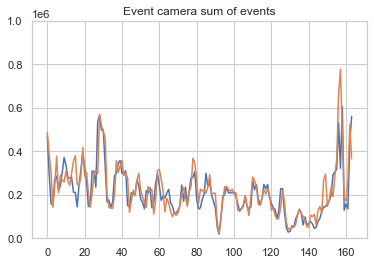

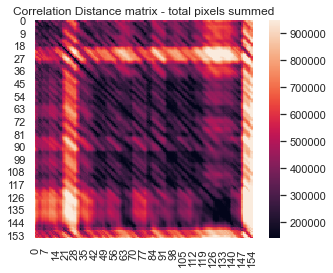

In [5]:
#plot the sum of events over all pixels over time
plt.figure()
for event_frame_total in event_frames_thresh:
    print(event_frame_total.shape)
    plt.plot(np.arange(len(event_frame_total)), event_frame_total.sum(axis=(1,2))) #sum over pixel axes to get total events for each binned time step
plt.ylim(0, 1e6)
plt.title('Event camera sum of events')

ref_summed = event_frames_thresh[0].sum(axis=(1,2))
qry_summed = event_frames_thresh[1].sum(axis=(1,2))
dMat_pixels_summed = apply_filter(ref_summed, qry_summed, 10, 'diff', 'time')

plt.figure()
sns.heatmap(dMat_pixels_summed, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix - total pixels summed')

np.savez("Results/dMat_pixels_summed.npz", dMat_pixels_summed = dMat_pixels_summed)
# print(dMat_pixels_summed)

SALIENCY DETERMINATION: Event count mean over the time axis to determine the most active pixels

(260, 346)
(164, 260, 346)


<AxesSubplot:title={'center':'Event camera mean of events'}>

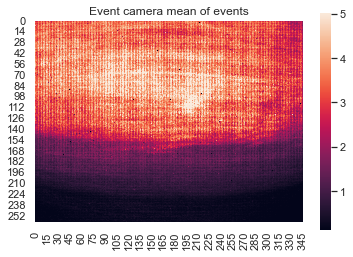

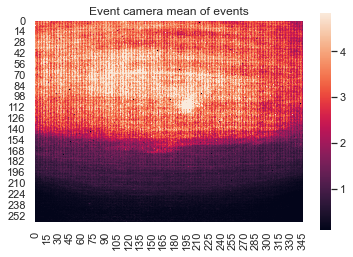

In [6]:
#plot the mean over the time axis to get an indication of the most active pixels
event_means = [event_frame_total.mean(axis=0) for event_frame_total in event_frames_thresh] #take the mean over the time dimension
print(event_means[1].shape)
print(event_frames_thresh[1].shape)
plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[1], robust=True, square=True, cbar=True)

plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[0], robust=True, square=True, cbar=True)

COMPARISON 2: Profile matching for a single pixel with smoothing filter applied. Parameters that can be adjusted - smoothing filter size, comparison filter size

(260, 346)
Number of events for pixel index 25468: 1206
x pixel: 210, y pixel: 73


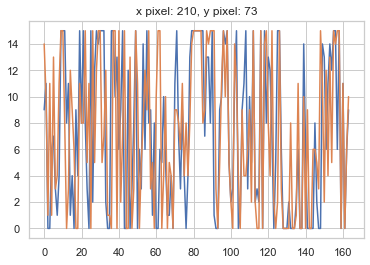

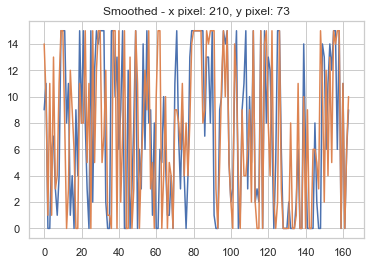

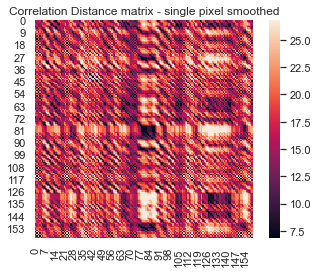

In [7]:
pixel_index = 0
smoothing_filter = 1
comparison_filter = 5
comparison_technique = "diff" #diff could either be L2 or L1 norm

print(event_means[0].shape)
# print(np.argmax(event_means[0])) #index of pixel with most events
# print(np.argsort(event_means[0], axis = None)[::-1]) #pixel indices sorted in order of most pixels to least
# print(np.unravel_index(np.argmax(event_means[0]), event_means[0].shape)) #coordinates of pixel with most events

top_pixels = np.argsort(event_means[0], axis = None)[::-1]
pixel = np.unravel_index(top_pixels[pixel_index], event_means[0].shape)
test_pixel_x = pixel[1]
test_pixel_y = pixel[0]

ref_smoothed = moving_average(event_frames_thresh[0][:, test_pixel_y, test_pixel_x], smoothing_filter)
qry_smoothed = moving_average(event_frames_thresh[1][:, test_pixel_y, test_pixel_x], smoothing_filter)
dMat_single_pix = apply_filter(ref_smoothed, qry_smoothed, comparison_filter, comparison_technique)



print('Number of events for pixel index ' +str(top_pixels[pixel_index]) + ": "+ str(np.sum((event_frame_total[:, test_pixel_y, test_pixel_x]))))
print('x pixel: ' + str(test_pixel_x) + ', y pixel: ' + str(test_pixel_y))
# Single pixel
plt.figure()
plt.title('x pixel: ' + str(test_pixel_x) + ', y pixel: ' + str(test_pixel_y))
for event_frame_total in event_frames_thresh:
    plt.plot(np.arange(len(event_frame_total)), event_frame_total[:, test_pixel_y, test_pixel_x])
    # print(event_frame_total.shape)

plt.figure()
plt.title('Smoothed - x pixel: ' + str(test_pixel_x) + ', y pixel: ' + str(test_pixel_y))

for event_frame_total in event_frames_thresh:
    plt.plot(np.arange(len(event_frame_total)-smoothing_filter+1), moving_average(event_frame_total[:, test_pixel_y, test_pixel_x], smoothing_filter))
    # print(event_frame_total.shape)

# dMat_single_pix[dMat_single_pix > 500] = 500
plt.figure()
sns.heatmap(dMat_single_pix, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix - single pixel smoothed')

np.savez("Results/dMat_pixel_x" + str(test_pixel_x) + "_y" + str(test_pixel_y) + ".npz", dMat_single_pix = dMat_single_pix)

In [8]:
a = np.arange(10)
f = np.arange(3)
print(f)
print(a)
s1=np.correlate(a,f)
s2=np.correlate(f,a)

print(s1)
print(s2)

print(f*f)

cdist(f.reshape(3,1),f.reshape(3,1),'euclidean')

[0 1 2]
[0 1 2 3 4 5 6 7 8 9]
[ 5  8 11 14 17 20 23 26]
[26 23 20 17 14 11  8  5]
[0 1 4]


array([[0., 1., 2.],
       [1., 0., 1.],
       [2., 1., 0.]])

COMPARISON 3: Profile matching for multiple pixels. Distance matrix constucted for each pixel and summed. 

In [17]:

smoothing_filter = 1
comparison_filter=15
number_of_pixels=10
correlation_method = 'diff'

print(event_frames_thresh.shape)

total_number_pixels = event_frames_thresh[0].shape[1]*event_frames_thresh[0].shape[2]
dmat_cumulative = np.zeros((len(event_frames_thresh[0])-comparison_filter+1,len(event_frames_thresh[0])-comparison_filter+1))

arr = np.arange(total_number_pixels)
# print(arr)
# np.random.shuffle(arr) #random selection of pixels
arr = top_pixels


for pixel_ind in tqdm(arr[0:number_of_pixels]):

    y_pix, x_pix  = np.unravel_index(pixel_ind, event_means[0].shape)
    # print("x pixel: " + str(x_pix) + ", y pixel:" + str(y_pix))
    ref = event_frames_thresh[0][:, y_pix, x_pix]
    qry = event_frames_thresh[1][:, y_pix, x_pix]
    # print(ref)
    ref_smoothed = moving_average(ref, smoothing_filter)
    qry_smoothed = moving_average(qry, smoothing_filter)
    dmat = apply_filter(ref_smoothed, qry_smoothed, comparison_filter, correlation_method)
    dmat_cumulative += dmat

dmat_cumulative /= np.max(dmat_cumulative)

if correlation_method == "corr":
    dmat_cumulative = 1-dmat_cumulative

sns.heatmap(dmat_cumulative, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix event camera')

# np.savez("Results/dMat_test.npz", dMat=dmat_cumulative)

(2, 164, 260, 346)


  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (150,150) (146,146) (150,150) 

COMPARISON 4 -  ref and qry time series profiles of all pixels summed. Difference 

torch.Size([1, 1, 10, 10])
(164, 260, 346)
(164, 1)
(164, 1)
dmat shape (164, 164)
(164, 1)


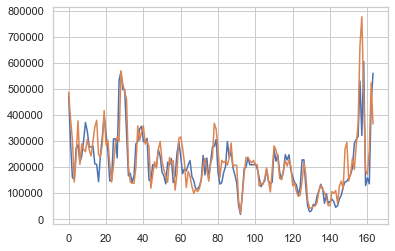

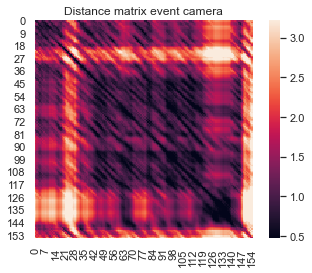

In [10]:
seq_length = 10
precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
print(precomputed_convWeight.shape)

ref_traverse = 0
query_traverse = 1
print(event_frames_thresh[ref_traverse].shape)
# ref_vec = event_frames_thresh[ref_traverse].reshape(event_frames_thresh[ref_traverse].shape[0], -1)
ref_vec = event_frames_thresh[0].sum(axis=(1,2)).reshape(event_frames_thresh[ref_traverse].shape[0], -1)

# qry_vec = event_frames_thresh[query_traverse].reshape(event_frames_thresh[query_traverse].shape[0], -1)
qry_vec = event_frames_thresh[1].sum(axis=(1,2)).reshape(event_frames_thresh[ref_traverse].shape[0], -1)

print(ref_vec.shape)
print(qry_vec.shape)

dMat = cdist(ref_vec, qry_vec ,'euclidean')
dMat /= np.max(dMat)
# dMat = 1 - dMat
print("dmat shape " + str(dMat.shape))
# print(dist_matrices_summed.shape)

dMat_seqslam = torch.nn.functional.conv2d(torch.from_numpy(dMat).float().unsqueeze(0).unsqueeze(0), precomputed_convWeight).squeeze()
# dMat_seqslam /= torch.max(dMat_seqslam)
# dMat_seqslam = 1 - dMat_seqslam

# print(dMat.shape)

print(ref_vec.shape)

plt.figure()
plt.plot(np.arange(len(event_frame_total)), ref_vec)
plt.plot(np.arange(len(event_frame_total)), qry_vec)

plt.figure()
sns.heatmap(dMat_seqslam, robust=True, square=True, cbar=True)
_ = plt.title('Distance matrix event camera')

np.savez("Results/dMat_test2.npz", dMat=dMat)


(2, 164, 260, 346)
Height: 260
Width: 346
Prob to draw from shape: (260, 346)
torch.Size([1, 1, 15, 15])


  0%|          | 0/1 [00:00<?, ?it/s]

{10: []}
{10: []}
Num of target pixels: 10
torch.Size([150, 150])


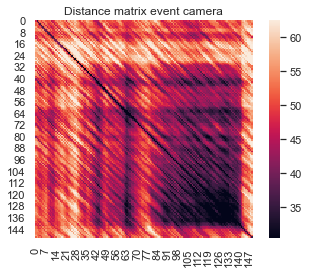

In [11]:
im_height = event_frames_thresh.shape[2]
im_width = event_frames_thresh.shape[3]

print(event_frames_thresh.shape)
print("Height: " + str(im_height))
print("Width: " + str(im_width))

prob_to_draw_from = np.copy(event_means[0])
print("Prob to draw from shape: " + str(prob_to_draw_from.shape))
# prob_to_draw_from[np.logical_and(prob_to_draw_from < 0.5, prob_to_draw_from != 0.0)] = 0.01

# Set low prob for "hot pixels"
prob_to_draw_from[prob_to_draw_from > (event_means[0].mean() + 2*event_means[0].std())] = 0.01
prob_sum = prob_to_draw_from.sum()
prob_to_draw_from = prob_to_draw_from / prob_sum

recall_dict = {}
used_pixels_dict = {}
use_saliency = True

seq_length = 15
maxLocRad = 4
gt_tolerance = maxLocRad
precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

print(precomputed_convWeight.shape)

num_trials = 1 #if we want to run a monte carlo 

# num_target_pixels_list = [1, 2, 5, 10, 20, 50, 100, 150, 200, 250]
num_target_pixels_list = [10]

for num_target_pixels in tqdm(num_target_pixels_list):
    if num_target_pixels in recall_dict:
        tqdm.write('skip')
        continue

    recall_dict[num_target_pixels] = []
    used_pixels_dict[num_target_pixels] = []
    print(recall_dict)
    print(used_pixels_dict)

    for _ in range(num_trials):
        target_pixels = []
        while len(target_pixels) < num_target_pixels:
            random_idx_flat = np.random.choice(np.arange(0, im_height*im_width), p=prob_to_draw_from.reshape(-1) if use_saliency else None)
            # random_idx_flat = im_height*im_width-1
            random_pixel = np.unravel_index(random_idx_flat, (im_height, im_width))
            # print("random_pixel: " + str(random_pixel))
            # if len(target_pixels) == 0 or np.all(np.linalg.norm(np.array(target_pixels) - np.array(random_pixel), axis=1) > 3):
            target_pixels.append(random_pixel)
        print("Num of target pixels: " + str(len(target_pixels)))

        dist_matrices = []
        for target_pixel in target_pixels:
            # print("Target pixel: " + str(target_pixel))
            count_traverse_ref = torch.from_numpy(event_frames_thresh[0,:, target_pixel[0], target_pixel[1]].astype(np.float32)).unsqueeze(0)
            count_traverse_qry = torch.from_numpy(event_frames_thresh[1,:, target_pixel[0], target_pixel[1]].astype(np.float32)).unsqueeze(0)
            dist_matrix_single = torch.abs(count_traverse_ref.unsqueeze(2) - count_traverse_qry.unsqueeze(1)).to('cpu').type(torch.FloatTensor).unsqueeze(0).squeeze(-1)
            dist_matrices.append(dist_matrix_single)

        dist_matrices_stacked = torch.stack(dist_matrices)
        dist_matrices_summed = torch.mean(dist_matrices_stacked, 0)
        dist_matrix_seqslam = torch.nn.functional.conv2d(dist_matrices_summed, precomputed_convWeight).squeeze()

print(dist_matrix_seqslam.shape)
plt.figure()
sns.heatmap(dist_matrix_seqslam, robust=True, square=True, cbar=True)
_ = plt.title('Distance matrix event camera')

In [12]:
a = np.array([[1,2,3,4],[5,6,7,8]])
print(a)
print(a.shape)

ind = 7
test = np.unravel_index(ind,a.shape)
print("test:" + str(test))

[[1 2 3 4]
 [5 6 7 8]]
(2, 4)
test:(1, 3)


(20,)
max correlation index: 0
truth correlation index: 0
[ 5  4  0  0 10  5  3  1  4  1  6  1  3 11 14 11  1  2  9  6]
[ 6  0  6  7 10  2  1  0  4  5 12  4 11 15  7  4  2  6  6 10]


/Users/ryanblackmore/opt/miniconda3/envs/eventVPR/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/ryanblackmore/opt/miniconda3/envs/eventVPR/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(145, 145)
(164,)


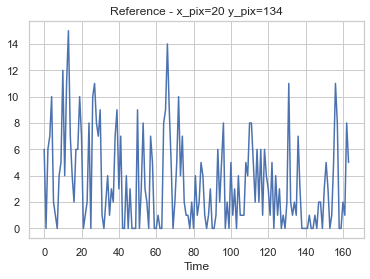

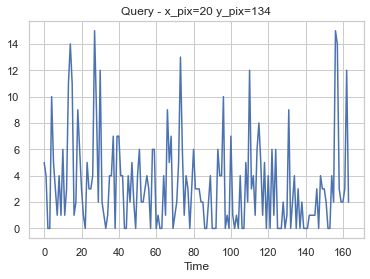

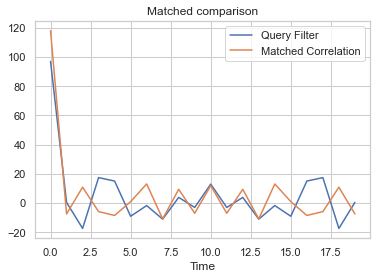

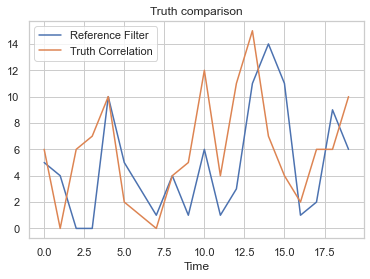

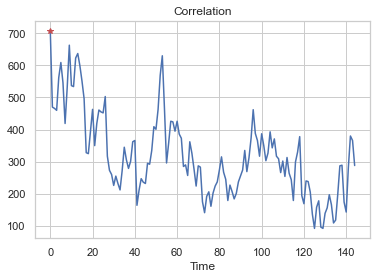

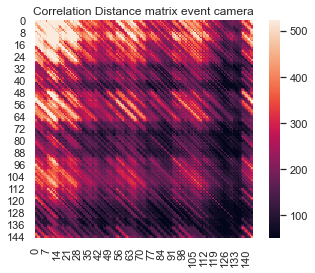

In [13]:

x_pix = 20
y_pix = 134

# x_pix = 120
# y_pix = 259

ref = event_frames_thresh[0][:, y_pix, x_pix]
# print(event_frames_total_cropped[0].shape)
# print(ref.shape)
qry = event_frames_thresh[1][:,y_pix,x_pix]

filter_size = 20

filter_ind = 0
filter = qry[filter_ind:filter_ind+filter_size]
print(filter.shape)
corr = np.correlate(ref, filter)
max_corr = np.max(corr)
max_corr_ind = np.where(corr==max_corr)[0][0]
print("max correlation index: " + str(max_corr_ind))
print("truth correlation index: " + str(filter_ind))

i = max_corr_ind
print(filter)
print(ref[i:i+filter_size])

plt.figure()
plt.title("Reference - x_pix=" + str(x_pix) + " y_pix=" + str(y_pix))
plt.plot(np.arange(len(ref)), ref)
plt.xlabel("Time")

plt.figure()
plt.title("Query - x_pix=" + str(x_pix) + " y_pix=" + str(y_pix))
plt.plot(np.arange(len(qry)), qry)
plt.xlabel("Time")

plt.figure()
plt.title("Matched comparison")
plt.plot(np.arange(filter_size), np.fft.fft(filter))
plt.plot(np.arange(filter_size), np.fft.fft(ref[i:i+filter_size]))
plt.legend(["Query Filter", "Matched Correlation"])
plt.xlabel("Time")
# print(np.fft.fft(filter))

plt.figure()
plt.title("Truth comparison")
plt.plot(np.arange(filter_size), filter)
plt.plot(np.arange(filter_size), ref[filter_ind:filter_ind+filter_size])
plt.legend(["Reference Filter", "Truth Correlation"])
plt.xlabel("Time")

plt.figure()
plt.title("Correlation")
plt.plot(np.arange(len(corr)), corr)
plt.plot(max_corr_ind, max_corr, 'r*')
plt.xlabel("Time")

dmat_corr = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))
print(dmat_corr.shape)
print(ref.shape)
for filter_ind in np.arange(len(ref)-filter_size+1):
    filter = qry[filter_ind:filter_ind+filter_size]
    corr = np.correlate(ref, filter)

    corr_diff = np.zeros(corr.shape)
    for idx in np.arange(len(corr_diff)):
        corr_diff[idx] = np.sum(np.abs(ref[idx:idx+filter_size] - filter))
    corr_norm = corr / np.max(corr)
    corr_diff_norm = corr_diff / np.max(corr_diff)
    dmat_corr[:,filter_ind] = corr

plt.figure()
sns.heatmap(dmat_corr, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix event camera')